# Deep Q-Network Variant Categorical 51-Atom DQN (C-51) implementation (PyTorch).

In this notebook, we will implement C51 (Categorical DQN) variant of DQN. First part of the notebook is all about the vanilla DQN and how we train - a copy of `6_1_dqn_pytorch.ipynb`. The C51 variant is after these sections on vanilla DQN.


### RECAP

$$ 
\DeclareMathOperator*{\max}{max}$$

Q Learning control is carried out by sampling step by step and updating Q values at each step. We use ε-greedy policy to explore and generate samples. However, the policy learnt is a deterministic greedy policy with no exploration. We can carryout updates online i.e. we take a step and use `(current state, action, reward and next_state)` tuple to update. 

In case of function approximation using neural network, the input to the network is the state and output is the q(s,a) for all the actions in the state `s`. It is denoted as $ \hat{q}(s_t,a; w_{t}) $, where $w_{t}$ is the weights of the neural network which we are trying to learn as part of DQN learning. 

We use two networks, one target network to get the max q-value of next state denoted by $ \max_a \hat {q}(s_{t+1},a; w^{-}_{t}) $ and the primary network with weights $w_{t}$ which we are updated based on back propagation of the TD error through the network.

The Update equation is given below. This is the online version:
$$ w_{t+1} \leftarrow w_t + \alpha [ R_{t+1} + \gamma . \max_{a} \hat{q}(S_{t+1},a,w^{-}_{t}) – \hat{q}(S_t,A_t,w_t)] \nabla \hat{q}(S_t,A_t,w_t)$$

Online update with neural network with millions of weights does not work well. Accordingly, We use experience replay (aka Replay Buffer).  We use a behavior policy to explore the environment and store the samples `(s, a, r, s', done)` in a buffer. The samples are generated using an exploratory behavior policy while we improve a deterministic target policy using q-values. 

Therefore, we can always use older samples from behavior policy and apply them again and again. We can keep the buffer size fixed to some pre-determined size and keep deleting the older samples as we collect new ones. This process makes learning sample efficient by reusing a sample multiple times and also removing temporal dependence of the samples we would otherwise see while following a trajectory.

The update equation with batch update with minor modifications is given below. We collect samples of transitions (current state, action, reward, next state) in a buffer. Where each sample is denoted as a tuple: 

$$ (s_{i}, a_{i}, r_{i}, s^{'}_{i}, done_{i})$$

Subscript (i) denotes ith sample. We take N samples from experience replay selecting randomly and update the weights. Subscript (t) denotes the index of weight updates. If the current state is done, as denoted by `done` flag, the target is just the reward as terminal states have zero value. The final update equation is as given below:

$$w_{t+1} \leftarrow w_t + \alpha \frac{1}{N} \sum_{i=1}^{N} \left[ r_i + \left( (1-done_i) . \gamma .  \max_{a^{'}} \hat{q}(s_{i}^{'},a^{'};w^{-}_{t}) \right) – \hat{q}(s_i,a_i;w_t) \right] \nabla \hat{q}(s_i,a_i;w_t)$$


In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gym

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve, gaussian
import math
import os
import io
import base64
import time
from tqdm import trange
import glob
import random
from collections import namedtuple

from IPython.display import HTML, clear_output

%matplotlib inline


### Environment - CartPole 

We can use the setup here to run on any environment which has state as a single vector and actions are discrete. We will build it on Cart Pole and they try to run this on many other environments like Lunar Lander and others.


In [2]:
def make_env(env_name, seed=None):
    # remove time limit wrapper from environment
    env = gym.make(env_name).unwrapped
    if seed is not None:
        env.seed(seed)
    return env

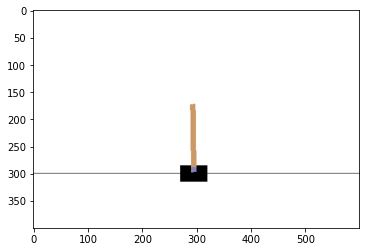

In [3]:
ENV_NAME = 'CartPole-v1'

env = make_env(ENV_NAME)
env.reset()
plt.imshow(env.render("rgb_array"))
state_shape, n_actions = env.observation_space.shape, env.action_space.n

### Building a network using pytorch

Let us build a DQN agent using a simple network. We now need to build a neural network that can map states/observations to state q-values. The observation space and action space is as given below for CartPole

    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right
        

The model will be a simple one with 2 hidden payers with Relu activation and final layer being logits with dimension equation to number of actions. 

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape
        
        state_dim = state_shape[0]
        # a simple NN with state_dim as input vector (inout is state s)
        # and self.n_actions as output vector of logits of q(s, a)
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 32)
        self.q = nn.Linear(32, n_actions)
        
    def forward(self, state_t):
        # pass the state at time t through the newrok to get Q(s,a)
        x = F.relu(self.fc1(state_t))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        qvalues = self.q(x)
        return qvalues

    def get_qvalues(self, states):
        # input is an array of states in numpy and outout is Qvals as numpy array
        states = torch.tensor(states, device=device, dtype=torch.float32)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        # sample actions from a batch of q_values using epsilon greedy policy
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [6]:
agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

In [7]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [8]:
print(evaluate(env, agent, n_games=1))
env.close()

11.0


### Experience replay

We will use the replay buffer we saw in chapter 4 listings. Replay buffer is very important in DQN to break the correlation between samples. We use a behavior policy (epsilon greedy) to sample from the environment and store the transitions (s,a,r,s',done) into a buffer. These samples are used multiple times in a learning making the process sample efficient. 

The interface to ReplayBuffer is:
* `exp_replay.add(state, action, reward, next_state, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns states, actions, rewards, next_states and done_flags for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

We have modified the implementation a bit to make it more efficient

In [9]:
class ReplayBuffer:
    def __init__(self, size):
        self.size = size #max number of items in buffer
        self.buffer =[] #array to holde buffer
        self.next_id = 0
    
    def __len__(self):
        return len(self.buffer)
    
    def add(self, state, action, reward, next_state, done):
        item = (state, action, reward, next_state, done)
        if len(self.buffer) < self.size:
           self.buffer.append(item)
        else:
            self.buffer[self.next_id] = item
        self.next_id = (self.next_id + 1) % self.size
        
    def sample(self, batch_size):
        idxs = np.random.choice(len(self.buffer), batch_size)
        samples = [self.buffer[i] for i in idxs]
        states, actions, rewards, next_states, done_flags = list(zip(*samples))
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(done_flags)

In [10]:
def play_and_record(start_state, agent, env, exp_replay, n_steps=1):

    s = start_state
    sum_rewards = 0

    # Play the game for n_steps and record transitions in buffer
    for _ in range(n_steps):
        qvalues = agent.get_qvalues([s])
        a = agent.sample_actions(qvalues)[0]        
        next_s, r, done, _ = env.step(a)
        sum_rewards += r
        exp_replay.add(s, a, r, next_s, done)
        if done:
            s = env.reset()
        else:
            s = next_s
        
    return sum_rewards, s

### Target network


In [11]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

### Learning with... Q-learning
Here we write a function similar to tabular q-learning. We will calculate average TD error per batch using the equation: 

$$ L =  \frac{1}{N} \sum_{i=1}^{N} \left[ r_i + \left( (1-done_i) . \gamma .  \max_{a^{'}} \hat{q}(s_{i}^{'},a^{'};w^{-}_{t}) \right) – \hat{q}(s_i,a_i;w_t) \right]^2$$


$$ \nabla_w L =   - \frac{1}{N} \sum_{i=1}^{N} \left[ r_i + \left( (1-done_i) . \gamma .  \max_{a^{'}} \hat{q}(s_{i}^{'},a^{'};w^{-}_{t}) \right) – \hat{q}(s_i,a_i;w_t) \right] \nabla \hat{q}(s_i,a_i;w_t)$$


$\hat{q}(s',A;w^{-})$ is calculated using target network whose weights are held constant and refreshed periodically from the agent learning network. 

Target is given by following:
* non terminal state: $r_i +  \gamma .  \max_{a^{'}} \hat{q}(s_{i}^{'},a^{'};w^{-}_{t})$
* terminal state: $ r_i $

We then carryout back propagation through the agent network to update the weights using equation below:


$$ 
\DeclareMathOperator*{\max}{max} w_{t+1} \leftarrow w_t - \alpha \nabla_{w}L$$

In [12]:
def td_loss_dqn(agent, target_network, states, actions, rewards, next_states, done_flags,
                    gamma=0.99, device=device):

    # convert numpy array to torch tensors
    states = torch.tensor(states, device=device, dtype=torch.float)
    actions = torch.tensor(actions, device=device, dtype=torch.long)
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    done_flags = torch.tensor(done_flags.astype('float32'),device=device,dtype=torch.float)

    # get q-values for all actions in current states
    # use agent network
    q_s = agent(states)

    # select q-values for chosen actions
    q_s_a = q_s[range(
        len(actions)), actions]

    with torch.no_grad():
        # compute q-values for all actions in next states
        # use target network
        q_s1 = target_network(next_states)


        # compute Qmax(next_states, actions) using predicted next q-values
        q_s1_a1max,_ = torch.max(q_s1, dim=1)

        # compute "target q-values" 
        target_q = rewards + gamma * q_s1_a1max * (1-done_flags)

    # mean squared error loss to minimize
    loss = torch.mean((q_s_a - target_q.detach()) ** 2)

    return loss

In [13]:
def epsilon_schedule(start_eps, end_eps, step, final_step):
    return start_eps + (end_eps-start_eps)*min(step, final_step)/final_step

def smoothen(values):
    kernel = gaussian(100, std=100)
    kernel = kernel / np.sum(kernel)
    return convolve(values, kernel, 'valid')

### Main loop

We now carryout the training on DQN setup above.

In [14]:
def train_agent(env, agent, target_network, optimizer, td_loss_fn):
    
    state = env.reset()
    # let us fill experience replay with some samples using full random policy
    exp_replay = ReplayBuffer(10**4)
    for i in range(100):
        play_and_record(state, agent, env, exp_replay, n_steps=10**2)
        if len(exp_replay) == 10**4:
            break
    print('Finished filling buffer with: {} samples'.format(len(exp_replay)))

    mean_rw_history = []
    td_loss_history = []
    state = env.reset()
    for step in trange(total_steps + 1):

        # reduce exploration as we progress
        agent.epsilon = epsilon_schedule(start_epsilon, end_epsilon, step, eps_decay_final_step)

        # take timesteps_per_epoch and update experience replay buffer
        _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

        # train by sampling batch_size of data from experience replay
        states, actions, rewards, next_states, done_flags = exp_replay.sample(batch_size)


        # loss = <compute TD loss>
        optimizer.zero_grad()
        loss = td_loss_fn(agent, target_network, 
                          states, actions, rewards, next_states, done_flags,                  
                          gamma=0.99,
                          device=device)

        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
        optimizer.step()

        if step % loss_freq == 0:
            td_loss_history.append(loss.data.cpu().item())

        if step % refresh_target_network_freq == 0:
            # Load agent weights into target_network
            target_network.load_state_dict(agent.state_dict())

        if step % eval_freq == 0:
            # eval the agent
            mean_rw_history.append(evaluate(
                make_env(ENV_NAME, seed=step), agent, n_games=3, greedy=True, t_max=1000)
            )

            clear_output(True)
            print("buffer size = %i, epsilon = %.5f" %
                  (len(exp_replay), agent.epsilon))

            plt.figure(figsize=[16, 5])
            plt.subplot(1, 2, 1)
            plt.title("Mean reward per episode")
            plt.plot(mean_rw_history)
            plt.grid()

            assert not np.isnan(td_loss_history[-1])
            plt.subplot(1, 2, 2)
            plt.title("TD loss history (smoothened)")
            plt.plot(smoothen(td_loss_history))
            plt.grid()

            plt.show()
    

In [15]:
#setup some parameters for training
timesteps_per_epoch = 1
batch_size = 32
total_steps = 3 * 10**4

# set exploration epsilon 
start_epsilon = 1
end_epsilon = 0.05
eps_decay_final_step = 2 * 10**4

# setup spme frequency for loggind and updating target network
loss_freq = 50
refresh_target_network_freq = 100
eval_freq = 1000

# to clip the gradients
max_grad_norm = 5000

#set up random numbers
seed=0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) 

#init environment
ENV_NAME = 'CartPole-v1'
env = make_env(ENV_NAME, seed)
state_dim = env.observation_space.shape
n_actions = env.action_space.n

#init agent, target network and Optimizer
agent = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network.load_state_dict(agent.state_dict())
optimizer = torch.optim.Adam(agent.parameters(), lr=1e-4)

buffer size = 10000, epsilon = 0.05000


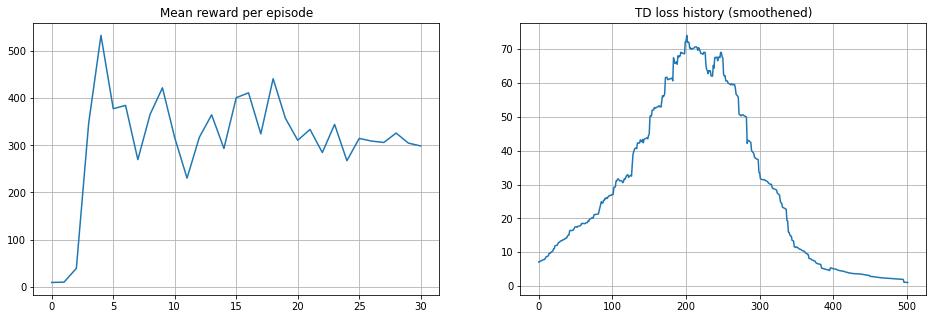

100%|███████████████████████████████████████████████████████████████████████████| 30001/30001 [02:39<00:00, 188.40it/s]


In [16]:
train_agent(env, agent, target_network, optimizer, td_loss_fn=td_loss_dqn)

In [17]:
final_score = evaluate(
  make_env(ENV_NAME),
  agent, n_games=30, greedy=True, t_max=1000
)
print('final score:', final_score)


final score: 281.6666666666667


**Let us record a video of trained agent**

In [18]:
def generate_animation(env, agent, save_dir):
    
    try:
        env = gym.wrappers.Monitor(
            env, save_dir, video_callable=lambda id: True, force=True, mode='evaluation')
    except gym.error.Error as e:
        print(e)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    state = env.reset()
    reward = 0
    while True:
        qvalues = agent.get_qvalues([state])
        action = qvalues.argmax(axis=-1)[0]
        state, r, done, _ = env.step(action)
        reward += r
        if done:
            print('Got reward: {}'.format(reward))
            break
            
def display_animation(filepath):
    video = io.open(filepath, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii')))

In [19]:
# Animate learned policy
save_dir='./videos/pytorch/6_7/'
env = make_env(ENV_NAME)
generate_animation(env, agent, save_dir=save_dir)
[filepath] = glob.glob(os.path.join(save_dir, '*.mp4'))
display_animation(filepath)


Got reward: 292.0


### Categorical 51-Atom DQN (C-51)

In the paper, https://arxiv.org/pdf/1707.06887.pdf , authors of the paper use a different route of distributional RL. Till now we have been outputting Q(s,a) values for an input state `s`. The number of units in output were of size `n_action`. In a way the output values were expected Q(s,a) using monte-carlo technique of averaging over a number of samples to form an estimate $\hat Q(s,a)$ of the actual expected value $E[Q(s,a)]$. 

In Categorical 51-Atom DQN, for each Q(s,a) (`n_action` of them), we now produce an estimate of the distribution of Q(s,a) values - `n_atom` values for each q(s,a). We are now trying to predict the entire distribution modeled as a categorical probability distribution instead of just estimating the mean value of Q(s,a). 

$$ Q(s,a) = \sum_i z_i p_i(s,a)$$ 

$p_i(s,a)$ is the probability that action-value at (s,a) will be $z_i$. 

We now have `n_action * n_atom` outputs, i.e. `n_atom` outputs for each value of `n_action`. Further these outputs are probabilities. For one action, we have `n_atom` probabilities and these are the probability of Q_value being in `-n_atom` discrete values in the range `V_min` to `V_max`. You can refer to the text or the linked paper above for more details. 

In C51 version of **distributional RL**, the authors took $i$ to be 51 atoms (support points) over the values -10 to 10. We will use the same setup in code below. As these values are parameterized in the code, you are welcomed to change these and explore the impact.

After bellman updates are applied, the values shift and there is a step of **projection** to bring back the probability distribution of Q(s,a) to the support points of **atoms**. 

The loss is also replaced from mean squared error to cross-entropy error. The agent is trained using a epsilon-greedy policy, similar to DQN. 

In [20]:
class CategoricalDQN(nn.Module):
    def __init__(self, state_shape, n_actions, n_atoms=51, Vmin=-10, Vmax=10, epsilon=0):
        
        super(CategoricalDQN, self).__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape        
        state_dim = state_shape[0]
        self.n_atoms = n_atoms
        self.Vmin = Vmin
        self.Vmax = Vmax
        # a simple NN with state_dim as input vector (inout is state s)
        # and self.n_actions as output vector of logits of q(s, a)
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 32)
        self.probs = nn.Linear(32, n_actions * n_atoms)
        
    def forward(self, state_t):
        # pass the state at time t through the newrok to get Q(s,a)
        x = F.relu(self.fc1(state_t))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        probs = F.softmax(self.probs(x).view(-1, self.n_actions, self.n_atoms), dim=-1)
        return probs

    def get_probs(self, states):
        # input is an array of states in numpy and outout is Qvals as numpy array
        states = torch.tensor(states, device=device, dtype=torch.float32)
        probs = self.forward(states)
        return probs.data.cpu().numpy()

    def get_qvalues(self, states):
        # input is an array of states in numpy and outout is Qvals as numpy array
        states = torch.tensor(states, device=device, dtype=torch.float32)
        probs = self.forward(states)
        support = torch.linspace(self.Vmin, self.Vmax, self.n_atoms)
        qvals = support * probs
        qvals = qvals.sum(-1)
        return qvals.data.cpu().numpy()

    def sample_actions(self, qvalues):
        # sample actions from a batch of q_values using epsilon greedy policy
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [21]:
def compute_projection(model, next_states, rewards, done_flags, gamma=0.99, n_atoms=51, Vmin=-10, Vmax=10):
    batch_size = next_states.size()[0]

    d_z = (Vmax - Vmin) / (n_atoms-1)
    support = torch.linspace(Vmin, Vmax, n_atoms)
    probs = model(next_states)
    qvals = support * probs
    best_actions = qvals.sum(-1).argmax(-1)
    best_actions = best_actions.unsqueeze(1).unsqueeze(1).expand(probs.size(0), 1, probs.size(2))
    best_qvals = qvals.gather(1,best_actions).squeeze(1)
    
    rewards = rewards.unsqueeze(1).expand_as(best_qvals)
    done_flags   = done_flags.unsqueeze(1).expand_as(best_qvals)
    support = support.unsqueeze(0).expand_as(best_qvals)
    
    Tz = rewards + (1-done_flags) * gamma * support
    Tz = Tz.clamp(Vmin, Vmax)
    b = (Tz - Vmin) / (d_z)
    l = b.floor().long()
    u = b.ceil().long()
    
    projected_dist = torch.zeros(best_qvals.size())
    
    offset = torch.linspace(0, (batch_size - 1) * n_atoms, batch_size).long()\
                    .unsqueeze(1).expand(batch_size, n_atoms)

    proj_dist = torch.zeros(best_qvals.size())    
    proj_dist.view(-1).index_add_(0, (l + offset).view(-1), (best_qvals * (u.float() - b)).view(-1))
    proj_dist.view(-1).index_add_(0, (u + offset).view(-1), (best_qvals * (b - l.float())).view(-1))
    
    return proj_dist    
    
    

In [22]:
def td_loss_categorical_dqn(agent, target_network, states, actions, rewards, next_states, done_flags,
                    gamma=0.99, device=device):

    # convert numpy array to torch tensors
    states = torch.tensor(states, device=device, dtype=torch.float)
    actions = torch.tensor(actions, device=device, dtype=torch.long)
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    done_flags = torch.tensor(done_flags.astype('float32'),device=device,dtype=torch.float)


    dist = agent(states)
    batch_size, n_actions, n_atoms = dist.size()
    actions = actions.unsqueeze(1).unsqueeze(1).expand(batch_size, 1, n_atoms)
    dist = dist.gather(1, actions).squeeze(1)
    dist.clamp(0.01, 0.99)
    
    with torch.no_grad():
        proj_dist = compute_projection(target_network, next_states, rewards, done_flags, gamma)
    
    loss = - (proj_dist * dist.log()).sum(1).mean()
        
    return loss
    

In [23]:
#setup some parameters for training
timesteps_per_epoch = 1
batch_size = 32
total_steps = 3 * 10**4

# set exploration epsilon 
start_epsilon = 1
end_epsilon = 0.05
eps_decay_final_step = 2 * 10**4

# setup spme frequency for loggind and updating target network
loss_freq = 50
refresh_target_network_freq = 100
eval_freq = 1000

# to clip the gradients
max_grad_norm = 5000

#set up random numbers
seed=0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) 

#init environment
ENV_NAME = 'CartPole-v1'
env = make_env(ENV_NAME, seed)
state_dim = env.observation_space.shape
n_actions = env.action_space.n

#init agent, target network and Optimizer
agent = CategoricalDQN(state_dim, n_actions, epsilon=1).to(device)
target_network = CategoricalDQN(state_dim, n_actions, epsilon=1).to(device)
target_network.load_state_dict(agent.state_dict())
optimizer = torch.optim.Adam(agent.parameters(), lr=1e-4)

buffer size = 10000, epsilon = 0.05000


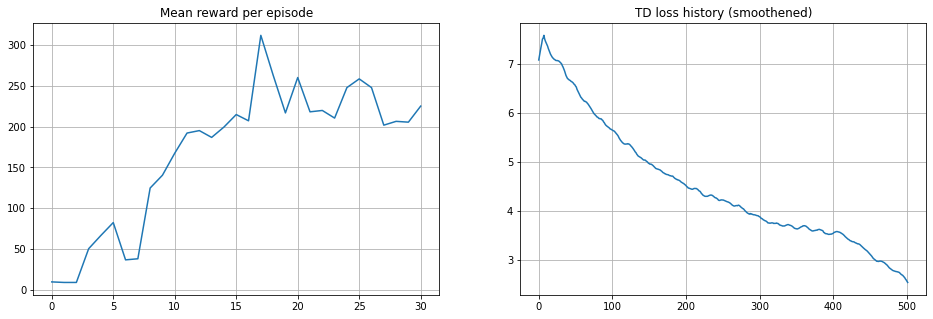

100%|███████████████████████████████████████████████████████████████████████████| 30001/30001 [04:42<00:00, 106.20it/s]


In [24]:
train_agent(env, agent, target_network, optimizer, td_loss_fn=td_loss_categorical_dqn)

In [25]:
final_score = evaluate(
  make_env(ENV_NAME),
  agent, n_games=30, greedy=True, t_max=1000
)
print('final score(C51 DQN): {:.0f}'.format(final_score))

final score(C51 DQN): 229


### Summary

In this notebook we saw how to train a DQN agent with experience replay and target networks. We also saw first variant under distributional RL i.e. **Distributional RL - Categorical DQN specifically 51-Atom (C51)**
